# Using PCA and forests for time-series forecasting

In [1]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

In [2]:
## The "environment" is our interface for code competitions
env = kagglegym.make()

## We get our initial observation by calling "reset"
observation = env.reset()
train = observation.train
    
## fill NaN's with mean values down columns
mean_values = train.mean(axis=0)

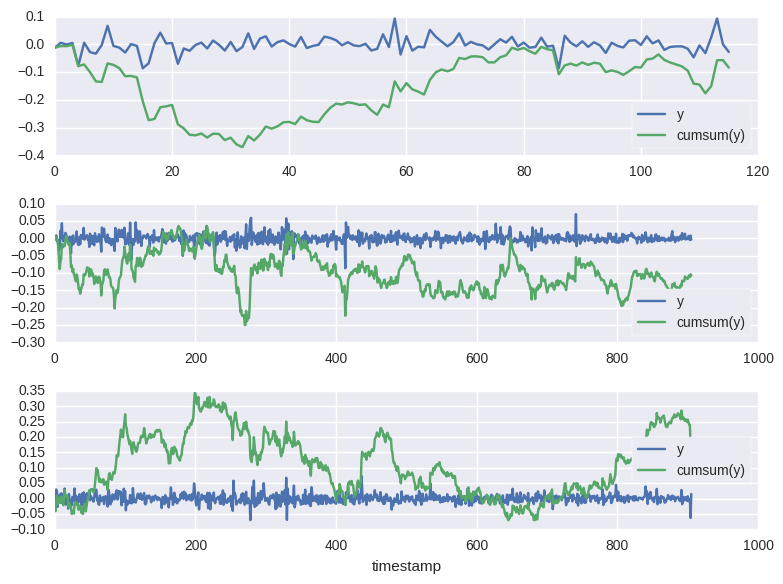

In [3]:
## peak at the target variable
id_gb = train.groupby(['id'])
# take a quick look at what these things might appear as
id_list = [10, 11, 12]
n_plots = len(id_list)
n_plot = 1
fig, ax = plt.subplots(figsize=(8,6))
for current_id in id_list:
    fig = plt.subplot(n_plots, 1, n_plot)
    data_df = id_gb.get_group(current_id)
    plt.plot(data_df.timestamp, data_df.y, label='y')
    plt.plot(data_df.timestamp, np.cumsum(data_df.y), label='cumsum(y)')
    plt.legend(loc='best', frameon=True)
    n_plot += 1
plt.xlabel('timestamp')
plt.tight_layout()

## Create NaN features

In [4]:
n = train.isnull().sum(axis=1)
all_features = [c for c in train.columns if c not in ['id', 'timestamp', 'y']]
train_pca = train[ ['id', 'timestamp', 'y'] ]
for c in all_features:
    train[c + '_nan_'] = pd.isnull(train[c])
    train_pca[c + '_nan_'] = train[c + '_nan_']
    mean_values[c+'_nan_'] = 0

train.fillna(mean_values, inplace=True)
train['znull'] = n
train_pca['znull'] = n

/opt/conda/bin/ipython:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sys.exit(IPython.start_ipython())
/opt/conda/bin/ipython:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
train_pca.head()

,id,timestamp,y,derived_0_nan_,derived_1_nan_,derived_2_nan_,derived_3_nan_,derived_4_nan_,fundamental_0_nan_,fundamental_1_nan_,...,technical_36_nan_,technical_37_nan_,technical_38_nan_,technical_39_nan_,technical_40_nan_,technical_41_nan_,technical_42_nan_,technical_43_nan_,technical_44_nan_,znull
0,10,0,-0.011753,False,False,False,False,False,False,False,...,False,True,True,True,False,True,True,False,True,24
1,11,0,-0.001240,False,False,False,False,False,False,False,...,False,True,True,True,False,True,True,False,True,22
2,12,0,-0.020940,False,False,False,False,False,False,False,...,False,True,True,True,False,True,True,False,True,28
3,25,0,-0.015959,True,True,True,True,True,False,True,...,False,True,True,True,False,True,True,False,True,38
4,26,0,-0.007338,False,False,False,False,False,False,False,...,False,True,True,True,False,True,True,False,True,21


## Feature extraction (scale and PCA)

In [6]:
## feature extraction with PCA
print('running PCA')

## features from exploration
derived_list = ['derived_%s' %l for l in range(0, 5)]
fundamental_list = ['fundamental_%s' %l for l in range(0, 64) if l not in [4]]
technical_list = ['technical_%s' %l for l in range(0, 45) if l not in [4, 8, 15, 23, 26]]
linear_features = ['technical_19', 'technical_20', 'technical_21', 'technical_24', 'technical_25']
# linear_features = ['technical_20']

    # 'derived' features
scaler_derived = StandardScaler().fit(train[derived_list].values)
derived_std = scaler_derived.transform(train[derived_list].values)
pca_derived = PCA().fit(derived_std)
print("explained variance of 'derived' features:", np.cumsum(pca_derived.explained_variance_ratio_))
derived_pca = pca_derived.transform(derived_std)
n_der = 2
for l in range(0,n_der):
    col = 'derived_PCA_%s' %l
    train_pca[col] = derived_pca[:,l]
    
    # 'fundamental' features
scaler_fundamental = StandardScaler().fit(train[fundamental_list])
fundamental_std = scaler_fundamental.transform(train[fundamental_list])
pca_fundamental = PCA().fit(fundamental_std)
print("explained variance of 'fundamental' features:", np.cumsum(pca_fundamental.explained_variance_ratio_))
fundamental_pca = pca_fundamental.transform(fundamental_std)
n_fund = 10
for l in range(0,n_fund):
    col = 'fundamental_PCA_%s' %l
    train_pca[col] = fundamental_pca[:,l]
    
    # 'technical' features
scaler_technical = StandardScaler().fit(train[technical_list])
technical_std = scaler_technical.transform(train[technical_list])
pca_technical = PCA().fit(technical_std)
print("explained variance of 'technical' features:", np.cumsum(pca_technical.explained_variance_ratio_))
technical_pca = pca_technical.transform(technical_std)
n_tech = 10
for l in range(0,n_tech):
    col = 'technical_PCA_%s' %l
    train_pca[col] = technical_pca[:,l]
    
features_pca = [col for col in train_pca if col not in ['id', 'timestamp', 'y']]

running PCA
explained variance of 'derived' features: [ 0.39968137  0.5996609   0.79962531  0.99954364  1.        ]


/opt/conda/bin/ipython:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


explained variance of 'fundamental' features: [ 0.06788408  0.12593945  0.17533402  0.21814157  0.25726326  0.29182431
  0.32580349  0.35758127  0.38732931  0.41678379  0.44235859  0.46779447
  0.49207604  0.51345289  0.53383245  0.55352058  0.57257168  0.59142776
  0.60911543  0.62565622  0.64173896  0.65767495  0.67354695  0.68933675
  0.70508909  0.72078151  0.73638344  0.75187125  0.76687456  0.7817182
  0.79644164  0.81089376  0.82500566  0.83877085  0.85156929  0.86407784
  0.87591976  0.88755004  0.898367    0.90872455  0.91871146  0.92791142
  0.93673886  0.94460397  0.95211794  0.95883947  0.9649101   0.97058814
  0.97591774  0.98103869  0.98589641  0.98943013  0.9921842   0.99481497
  0.99709722  0.99827008  0.99904763  0.99952288  0.99988877  0.99994655
  0.99999994  0.99999999  1.        ]


/opt/conda/bin/ipython:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


explained variance of 'technical' features: [ 0.15884115  0.24491905  0.30256739  0.34341714  0.37869352  0.40997392
  0.43931862  0.46689409  0.49350512  0.51955527  0.54527092  0.570944
  0.59630407  0.62151397  0.64661515  0.67154752  0.69623427  0.72068641
  0.74460839  0.76839759  0.79055923  0.81111521  0.82875337  0.84578344
  0.86180842  0.87569641  0.88920317  0.90173878  0.91329438  0.92470047
  0.93503718  0.9444603   0.95377275  0.96272174  0.97098715  0.97822248
  0.98525525  0.99095296  0.99625475  1.        ]


/opt/conda/bin/ipython:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Build and train prediction models (forests for speed)

In [7]:
## build and train predictions models
start_time = time()

   # clip ends of target (from histogram of y)
low_y_cut = np.min(train.y)
high_y_cut = np.max(train.y)
y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut) # not above high or below low
    # linear regression
print('Training linear regressor')
lr = LinearRegression(n_jobs=-1)
lr.fit(train.loc[y_is_within_cut, linear_features].values, train.loc[y_is_within_cut, 'y'])
# lr_pca = LinearRegression(n_jobs=-1)
# lr_pca.fit(train_pca.loc[y_is_within_cut, features_pca].values, train_pca.loc[y_is_within_cut, 'y'])
    # ExtraTreesRegressor
print('Training extra trees regressor')
etr = ExtraTreesRegressor(n_estimators=60, max_depth=5, n_jobs=-1, verbose=0, random_state=None)
etr.fit(train_pca[features_pca].values, train.y)
print('Training random forest regressor')
rtr = RandomForestRegressor(n_estimators=35, max_depth=5, n_jobs=-1, verbose=0, random_state=None)
#rtr = ExtraTreesRegressor(n_estimators=60, max_depth=5, n_jobs=-1, verbose=0, random_state=None)
rtr.fit(train_pca[features_pca].values, train.y)
    # time-series neural net model (one for each id?)
    
training_time = time() - start_time
print('Training time = {:.2f} minutes'.format(training_time/60))

Training linear regressor
Training extra trees regressor
Training random forest regressor
Training time = 10.24 minutes


## Predict the time-series

In [8]:
current_step = 0
while True:
    current_features = observation.features
    current_features_pca = pd.DataFrame()
    current_features_pca['id'] = current_features['id']
    n = current_features.isnull().sum(axis=1)
    for c in current_features.columns:
        current_features[c+'_nan_'] = pd.isnull(current_features[c])
        current_features_pca[c+'_nan_'] = current_features[c+'_nan_']
    current_features.fillna(mean_values, inplace=True)
    current_features['znull'] = n
    current_features_pca['znull'] = n
    
        # build 'derived' features
    current_derived_pca = pca_derived.transform(scaler_derived.transform(current_features[derived_list]))
    for l in range(0, n_der):
        col = 'derived_PCA_%s' %l
        current_features_pca[col] = current_derived_pca[:,l]
        
        # build 'fundamental' features
    current_fundamental_pca = pca_fundamental.transform(scaler_fundamental.transform(current_features[fundamental_list]))
    for l in range(0, n_fund):
        col = 'fundamental_PCA_%s' %l
        current_features_pca[col] = current_fundamental_pca[:,l]
        
        # build 'technical' features
    current_technical_pca = pca_technical.transform(scaler_technical.transform(current_features[technical_list]))
    for l in range(0, n_tech):
        col = 'technical_PCA_%s' %l
        current_features_pca[col] = current_technical_pca[:,l]
    
    ## make the prediction
    y_lr = lr.predict(current_features[linear_features].values).clip(low_y_cut, high_y_cut)
    y_etr = etr.predict(current_features_pca[features_pca].values).clip(low_y_cut, high_y_cut)
    y_rtr = rtr.predict(current_features_pca[features_pca].values).clip(low_y_cut, high_y_cut)
    w_lr = 0.2
    w_etr = 0.4
    w_rtr = 0.4
    y_pred = (w_lr*y_lr+w_etr*y_etr+w_rtr*y_rtr)/(w_lr+w_etr+w_rtr)

    target = observation.target
    target.y = y_pred

    ## We perform a "step" by making our prediction and getting back an updated "observation":
    observation, reward, done, info = env.step(target)
    
    ## report progress and stop at end of data stream
    if current_step % 100 == 0:
        print('current_step =', current_step)
    current_step = current_step + 1
    if done:
        print("Public score: {}".format(info["public_score"]))
        break

current_step = 0
current_step = 100
current_step = 200
current_step = 300
current_step = 400
current_step = 500
current_step = 600
current_step = 700
current_step = 800
current_step = 900
Public score: 0.023269308100891912


In [9]:
# etr + etr: 0.0198
# etr + rtr: 0.0229
print('completed')

completed
